<a href="https://colab.research.google.com/github/japanipsystem/Test/blob/master/0625_mhawkes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class UniRnd(object):
    def __init__(self, sz=100):
        self.sz = sz
        self.us = np.zeros(self.sz)
        self.pos = sz

    def get(self):
        if self.pos >= self.sz:
            self.us = np.random.uniform(0, 1, self.sz)
            self.pos = 0
        u = self.us[self.pos]
        self.pos += 1
        return(u)


class Zetad(object): # (5.4)
    def __init__(self, s, ceil, sz=100):
        self.s = s # parameter
        self.ceil = ceil # ceiling
        self.sz = sz
        self.vs = np.zeros(self.sz)
        self.pos = sz

    def get(self):
        if self.pos >= self.sz:
            vs = np.random.zipf(self.s, self.sz)
            self.vs = np.where(vs < self.ceil, vs, self.ceil)
            self.pos = 0
        v = self.vs[self.pos]
        self.pos += 1
        return(v)

In [ ]:
# Mutual-exciting Hawkes process
class MHawkes(object):
    def __init__(self, names, mu, alpha, beta, T):
        # parameters
        self.names = names # event types
        self.mu = mu
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.M = len(self.mu) # number of event types

        self.ur = UniRnd()

        # sequence of jump times
        self.tm = [] # list of marked jumps with shares [t, m, sh]

        self.ones = np.ones((self.M), dtype=float)

        self.zetad = Zetad(2.2, 50)
        self.events = []

    def set_seed(self, seed):
        np.random.seed(seed)

    def gen(self): # generate marked point process; i.e. a list of (time, event_type, shares)
        t = 0.0
        eta = np.zeros((self.M, self.M), dtype=float)   # (4.4)
        lmd = self.mu # vector of last lambda values    # (4.7)
        while True:
            lmd = self.mu + np.matmul(self.ones, eta) # (4.7)
            sumLmd = lmd.sum()
            s = np.random.exponential(sumLmd) # time interval until next 'something happens
            t += s
            if t > self.T:
                break
            d = self.ur.get()
            l = sumLmd * d
            m = -1  # then, what is 'something'?
            psl = 0.0
            while psl < l:
                m += 1
                if m >= self.M:
                    break
                psl += lmd[m]
            # we figured out what 'something' was. It's m.
            eta *= np.exp(- self.beta * s) # Case 1; proceed time immediately before 'm' happens; (4.11)
            # and then, update 'eta' just after 'm' happens
            eta[m] += self.alpha[m] # Case 2; (4.12)
            sh = self.zetad.get()   # get number of shares
            self.tm.append([t, m, sh])

    def lmbd(self, dt):
        steps = int(self.T / dt)
        lmd_t = np.zeros((steps, self.M), dtype=float) # [time, type]-matrix; will be transported at the return; (4.3)
        eta = np.zeros((self.M, self.M), dtype = float) # (4.4)
        """
        Homework (Exercise 4.3): make the matrix lmd_t by (4.7)
        """
        k = 0 # time in step
        for tm in self.tm:
            t = tm[0] # event time
            m = tm[1] # event type
            k0 = int(t / dt)
            if k0 * dt < t: k0 += 1
            # assume t <= k0 * dt
            k1 = k0
            if k1 >= steps: k1 -= 1
            while k < k1:
                k += 1
                eta *= np.exp(- self.beta * dt) # Caes 1: (4.9)
                lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
            if k == k0:
                eta[m] += self.alpha[m] # Case 2: (4.10)
                lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
        # all jumps have been processed
        while True:
            k += 1
            if k >= steps: break
            eta *= np.exp(- self.beta * dt) # Case 1: (4.9)
            lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
        """
        End of homework
        """
        return(np.transpose(lmd_t))

    def plot_lmd(self, dt, outf=''):
        f = plt.figure()
        f.set_size_inches(10,7)
        steps = int(self.T / dt)
        ts = dt * np.arange(steps)
        lmd = self.lmbd(dt) # [type, time]-matrix
        for m in range(self.M):
            plt.plot(ts, lmd[m], linewidth=2, label=self.names[m])
        plt.xlabel('time')
        plt.ylabel('lambda')
        plt.grid()
        plt.legend(loc='upper left', borderaxespad=3.0, fontsize=9)
        plt.show()
        if outf != '':
            f.savefig(outf + '.pdf', bbox_inches='tight')

    def make_events(self): # make the event list self.events according to self.tm.
        evs = [] # list of events
        """
        Homework (Exercese 5.5)
        """
        cur_sh = 0
        for tm in self.tm:
            t = tm[0] # event time
            m = tm[1] # event type
            s = tm[2] # event shares
            if m == 0:  # market ask
                if s > cur_sh: s = cur_sh
                if s > 0:
                    evs.append([t, 'MKA', s])
                    evs.append([t, 'EXE', s])
                    cur_sh -= s
                    evs.append([t, '-h'])
            elif m == 1:  # market bid
                if s > 0:
                    evs.append([t, 'MKB', s])
                    evs.append([t, 'EXE', s])
                    cur_sh += s
                    evs.append([t, '-h'])
            elif m == 2:  # limit ask
                evs.append([t, 'LMA', s])
                cur_sh += s
                evs.append([t, 'SH', cur_sh])
            elif m == 3:  # limit bid
                evs.append([t, 'LMB', s])
                cur_sh -= s
                evs.append([t, 'SH', cur_sh])
            elif m == 4:  # cancel market ask
                if s > cur_sh: s = cur_sh
                if s > 0:
                    evs.append([t, 'CNA', s])
                    cur_sh -= s
                    evs.append([t, 'SH', cur_sh])
            elif m == 5:  # cancel bid
                if s > 0:
                    evs.append([t, 'CNB', s])
                    cur_sh += s
                    evs.append([t, 'SH', cur_sh])
        self.events = evs
        """
        End of Homework (Exercese 5.5)
        """

    def print_tm(self):
        print(self.t)
        for tm in self.tm:
            print(tm)

    def print_events(self):
        for ev in self.events:
            print(ev)

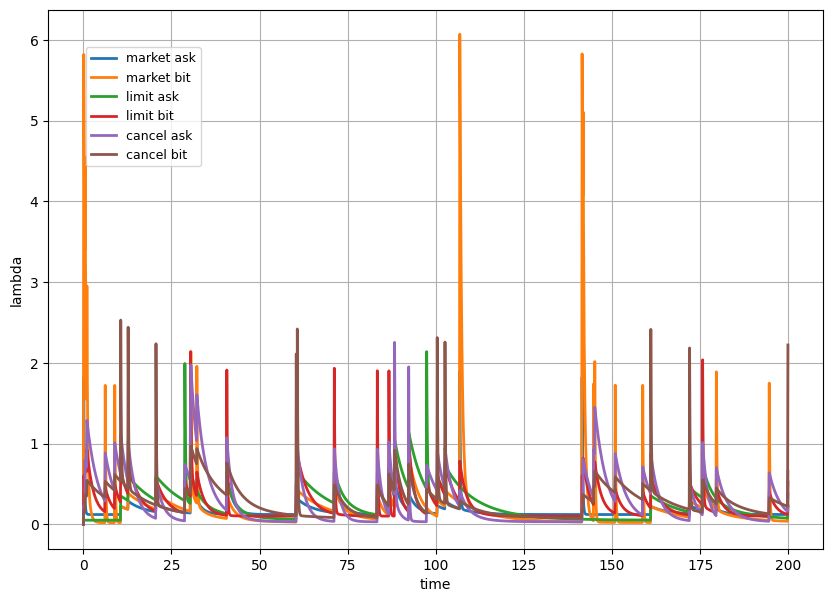

[0.45492996776444106, 'MKB', 1]
[0.45492996776444106, 'EXE', 1]
[0.45492996776444106, '-h']
[0.9199421536067587, 'MKB', 1]
[0.9199421536067587, 'EXE', 1]
[0.9199421536067587, '-h']
[6.110606015314778, 'MKB', 1]
[6.110606015314778, 'EXE', 1]
[6.110606015314778, '-h']
[8.87032528062031, 'MKB', 1]
[8.87032528062031, 'EXE', 1]
[8.87032528062031, '-h']
[10.525106678621942, 'CNB', 11]
[10.525106678621942, 'SH', 15]
[12.680393776358162, 'CNB', 2]
[12.680393776358162, 'SH', 17]
[20.523274458814914, 'CNB', 2]
[20.523274458814914, 'SH', 19]
[28.785034681482145, 'LMA', 1]
[28.785034681482145, 'SH', 20]
[30.335951786311036, 'LMB', 1]
[30.335951786311036, 'SH', 19]
[30.40074284891888, 'MKB', 1]
[30.40074284891888, 'EXE', 1]
[30.40074284891888, '-h']
[32.10176275484479, 'MKB', 1]
[32.10176275484479, 'EXE', 1]
[32.10176275484479, '-h']
[40.67196664150724, 'LMB', 1]
[40.67196664150724, 'SH', 20]
[60.3074133106133, 'CNB', 1]
[60.3074133106133, 'SH', 21]
[60.66114943948372, 'CNB', 1]
[60.66114943948372,

In [ ]:
if __name__ == '__main__':
    names = ['market ask', 'market bit', 'limit ask', 'limit bit', 'cancel ask', 'cancel bit']
    mu = np.array([0.12, 0.02, 0.05, 0.10, 0.03, 0.07])
    alpha = np.array([
    [1.7, 5.8, 0, 0.5, 0.2, 0.1],
    [0, 1.7, 0, 0.3, 0.6, 0.2],
    [0, 0, 1.7, 0.4, 0.7, 0.3],
    [0.5, 0.3, 0.4, 1.8, 0.9, 0.4],
    [0.2, 0.6, 0.7, 0.9, 1.9, 0.5],
    [0.1, 0.2, 0.3, 0.4, 0.5, 2.0]
])
    beta = np.array([
    [5.8, 1.8, 0, 0.6, 0.4, 0.2],
    [0, 6.0, 0, 0.5, 0.3, 0.1],
    [0, 0, 5.0, 0.4, 0.2, 0.1],
    [0.6, 0.5, 0.4, 5.9, 0.7, 0.3],
    [0.4, 0.3, 0.2, 0.7, 6.1, 0.5],
    [0.2, 0.1, 0.1, 0.3, 0.5, 6.2]
])

    T = 200.0
    hp = MHawkes(names, mu, alpha, beta, T)
    #hp.set_seed(1234)
    hp.gen()
    #hp.print_tm()
    hp.plot_lmd(0.1, 'Hawkes')
    hp.make_events()
    hp.print_events()

In [ ]:
"""""
'market ask', 'market bid', 'limit ask tier 2', 'limit bid tier 2', 'limit ask tier 1',
'limit bid tier 1', 'cancel ask', 'cancel bid'を導入、値段の変更はない。

"""""

class MHawkes(object):
    def __init__(self, names, mu, alpha, beta, T):
        # parameters
        self.names = names # event types
        self.mu = mu
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.M = len(self.mu) # number of event types

        self.ur = UniRnd()

        # sequence of jump times
        self.tm = [] # list of marked jumps with shares [t, m, sh]

        self.ones = np.ones((self.M), dtype=float)

        self.zetad = Zetad(2.2, 50)
        self.events = []

        # SA1 Askの株数、SM仲値の株数、SB1 Bitの株数
        self.SA1 = 0
        self.SM = 0
        self.SB1 = 0

    def set_seed(self, seed):
        np.random.seed(seed)

    def set_midprice(self, PM):
      #仲値情報を導入、まだ使用していない。
        self.PM = PM

    def gen(self): # generate marked point process; i.e. a list of (time, event_type, shares)
        t = 0.0
        eta = np.zeros((self.M, self.M), dtype=float)   # (4.4)
        lmd = self.mu # vector of last lambda values    # (4.7)
        while True:
            lmd = self.mu + np.matmul(self.ones, eta) # (4.7)
            sumLmd = lmd.sum()
            s = np.random.exponential(sumLmd) # time interval until next 'something happens
            t += s
            if t > self.T:
                break
            d = self.ur.get()
            l = sumLmd * d
            m = -1  # then, what is 'something'?
            psl = 0.0
            while psl < l:
                m += 1
                if m >= self.M:
                    break
                psl += lmd[m]
            # we figured out what 'something' was. It's m.
            eta *= np.exp(- self.beta * s) # Case 1; proceed time immediately before 'm' happens; (4.11)
            # and then, update 'eta' just after 'm' happens
            eta[m] += self.alpha[m] # Case 2; (4.12)
            sh = self.zetad.get()   # get number of shares
            self.tm.append([t, m, sh])

    def lmbd(self, dt):
        steps = int(self.T / dt)
        lmd_t = np.zeros((steps, self.M), dtype=float) # [time, type]-matrix; will be transported at the return; (4.3)
        eta = np.zeros((self.M, self.M), dtype = float) # (4.4)
        """
        Homework (Exercise 4.3): make the matrix lmd_t by (4.7)
        """
        k = 0 # time in step
        for tm in self.tm:
            t = tm[0] # event time
            m = tm[1] # event type
            k0 = int(t / dt)
            if k0 * dt < t: k0 += 1
            # assume t <= k0 * dt
            k1 = k0
            if k1 >= steps: k1 -= 1
            while k < k1:
                k += 1
                eta *= np.exp(- self.beta * dt) # Caes 1: (4.9)
                lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
            if k == k0:
                eta[m] += self.alpha[m] # Case 2: (4.10)
                lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
        # all jumps have been processed
        while True:
            k += 1
            if k >= steps: break
            eta *= np.exp(- self.beta * dt) # Case 1: (4.9)
            lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
        """
        End of homework
        """
        return(np.transpose(lmd_t))

    def plot_lmd(self, dt, outf=''):
        f = plt.figure()
        f.set_size_inches(10,7)
        steps = int(self.T / dt)
        ts = dt * np.arange(steps)
        lmd = self.lmbd(dt) # [type, time]-matrix
        for m in range(self.M):
            plt.plot(ts, lmd[m], linewidth=2, label=self.names[m])
        plt.xlabel('time')
        plt.ylabel('lambda')
        plt.grid()
        plt.legend(loc='upper left', borderaxespad=3.0, fontsize=9)
        plt.show()
        if outf != '':
            f.savefig(outf + '.pdf', bbox_inches='tight')

    def make_events(self):
        evs = [] # list of events
        """
        Homework (Exercese 5.5)
        """

        cur_sh = 0
        for tm in self.tm:
            t = tm[0] # event time
            m = tm[1] # event type
            s = tm[2] # event shares
            if m == 0:  # market ask
                if s > cur_sh: s = cur_sh
                if s > 0:
                    evs.append([t, 'MKA', s])
                    evs.append([t, 'EXE', s])
                    cur_sh -= s
                    evs.append([t, '-h'])
            elif m == 1:  # market bid
                if s > 0:
                    evs.append([t, 'MKB', s])
                    evs.append([t, 'EXE', s])
                    cur_sh += s
                    evs.append([t, '-h'])
            elif m == 2:  # limit ask tier 2
                self.SA1 += s
                evs.append([t, 'LMA2', s])
                evs.append([t, 'SH', cur_sh])
            elif m == 3:  # limit bid tier 2
                self.SB1 -= s
                evs.append([t, 'LMB2', s])
                evs.append([t, 'SH', cur_sh])
            elif m == 4:  # limit ask tier 1
                self.SM += s
                evs.append([t, 'LMA1', s])
                evs.append([t, 'SH', cur_sh])
            elif m == 5:  # limit bid tier 1
                self.SM -= s
                evs.append([t, 'LMB1', s])
                evs.append([t, 'SH', cur_sh])
            elif m == 6:  # cancel market ask
                if s > cur_sh: s = cur_sh
                if s > 0:
                    evs.append([t, 'CNA', s])
                    cur_sh -= s
                    evs.append([t, 'SH', cur_sh])
            elif m == 7:  # cancel bid
                if s > 0:
                    evs.append([t, 'CNB', s])
                    cur_sh += s
                    evs.append([t, 'SH', cur_sh])
        self.events = evs


    def print_tm(self):
        print(self.t)
        for tm in self.tm:
            print(tm)

    def print_events(self):
        for ev in self.events:
            print(ev)


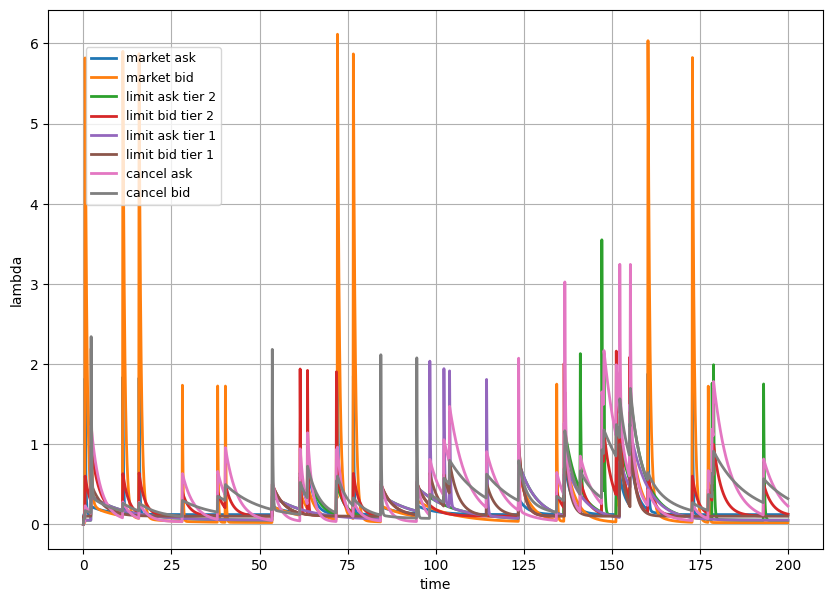

[2.153737200963038, 'MKB', 1]
[2.153737200963038, 'EXE', 1]
[2.153737200963038, '-h']
[2.1597508321770884, 'CNB', 4]
[2.1597508321770884, 'SH', 5]
[11.140095396756834, 'MKA', 1]
[11.140095396756834, 'EXE', 1]
[11.140095396756834, '-h']
[15.781947678479511, 'MKA', 1]
[15.781947678479511, 'EXE', 1]
[15.781947678479511, '-h']
[28.09478946681327, 'MKB', 1]
[28.09478946681327, 'EXE', 1]
[28.09478946681327, '-h']
[38.098467563584414, 'MKB', 1]
[38.098467563584414, 'EXE', 1]
[38.098467563584414, '-h']
[40.274438468625895, 'MKB', 1]
[40.274438468625895, 'EXE', 1]
[40.274438468625895, '-h']
[53.580683871837856, 'CNB', 1]
[53.580683871837856, 'SH', 7]
[61.49896884133862, 'LMB2', 1]
[61.49896884133862, 'SH', 7]
[63.50221269136941, 'LMB2', 1]
[63.50221269136941, 'SH', 7]
[71.7740087590899, 'LMB2', 4]
[71.7740087590899, 'SH', 7]
[72.07912265025739, 'MKA', 7]
[72.07912265025739, 'EXE', 7]
[72.07912265025739, '-h']
[84.37941689925324, 'CNB', 1]
[84.37941689925324, 'SH', 1]
[94.59424424838562, 'CNB', 

In [ ]:
if __name__ == '__main__':
    names = ['market ask', 'market bid', 'limit ask tier 2', 'limit bid tier 2', 'limit ask tier 1', 'limit bid tier 1', 'cancel ask', 'cancel bid']
    mu = np.array([0.12, 0.02, 0.05, 0.10, 0.05, 0.10, 0.03, 0.07])
    alpha = np.array([
        [1.7, 5.8, 0, 0.5, 0, 0, 0.2, 0.1],
        [0, 1.7, 0, 0.3, 0, 0, 0.6, 0.2],
        [0, 0, 1.7, 0.4, 0, 0, 0.7, 0.3],
        [0.5, 0.3, 0.4, 1.8, 0, 0, 0.9, 0.4],
        [0, 0, 0, 0, 1.7, 0.4, 0.7, 0.3],
        [0, 0, 0, 0, 0.5, 1.8, 0.9, 0.4],
        [0.2, 0.6, 0.7, 0.9, 0.7, 0.9, 1.9, 0.5],
        [0.1, 0.2, 0.3, 0.4, 0.3, 0.4, 0.5, 2.0]
    ])
    beta = np.array([
        [5.8, 1.8, 0, 0.6, 0, 0, 0.4, 0.2],
        [0, 6.0, 0, 0.5, 0, 0, 0.3, 0.1],
        [0, 0, 5.0, 0.4, 0, 0, 0.2, 0.1],
        [0.6, 0.5, 0.4, 5.9, 0, 0, 0.7, 0.3],
        [0, 0, 0, 0, 5.0, 0.4, 0.2, 0.1],
        [0, 0, 0, 0, 0.4, 5.9, 0.7, 0.3],
        [0.4, 0.3, 0.2, 0.7, 0.2, 0.7, 6.1, 0.5],
        [0.2, 0.1, 0.1, 0.3, 0.1, 0.3, 0.5, 6.2]
    ])

    T = 200.0
    PM = 50.0  # 仲値を設定

    hp = MHawkes(names, mu, alpha, beta, T)
    hp.set_midprice(PM)  # 仲値を設定
    #hp.set_seed(1234)
    hp.gen()
    #hp.print_tm()
    hp.plot_lmd(0.1, 'Hawkes')
    hp.make_events()
    hp.print_events()


In [ ]:
class UniRnd:
    def get(self):
        return np.random.uniform()

class Zetad:
    def __init__(self, param1, param2):
        self.param1 = param1
        self.param2 = param2

    def get(self):
        return np.random.zipf(self.param1)

class MHawkes(object):
    def __init__(self, names, mu, alpha, beta, T):
        # parameters
        self.names = names # event types
        self.mu = mu
        self.alpha = alpha
        self.beta = beta
        self.T = T
        self.M = len(self.mu) # number of event types
        self.tick = 1 # tickの幅

        self.ur = UniRnd()

        # sequence of jump times
        self.tm = [] # list of marked jumps with shares [t, m, sh]

        self.ones = np.ones((self.M), dtype=float)

        self.zetad = Zetad(2.2, 50)
        self.events = []

        # 全11個の値段行の定義
        self.order_book = np.zeros(11)

        # Initial price values
        self.mid_price_index = 5
        self.PM = 5  # 仲値の初期位置を5に設定
        self.PA = self.PM + self.tick
        self.PB = self.PM - self.tick
        self.PS = 0

    def set_seed(self, seed):
        np.random.seed(seed)

    def set_midprice(self, PM):
        self.mid_price_index = PM
        self.PM = PM
        self.PA = self.PM + self.tick
        self.PB = self.PM - self.tick

    def update_prices(self):
        # Calculate prices, definition of 20240502 p35
        kA = self.kA(self.order_book)
        kB = self.kB(self.order_book)
        self.PA = self.price_function_A(kA)
        self.PB = self.price_function_B(kB)
        self.PM = int((self.PA + self.PB) / 2)
        self.PS = self.PA - self.PB

        # 仲値の変化に応じて、値段行を更新する
        self.mid_price_index = self.PM

        # 値段行の範囲チェック
        if self.mid_price_index <= 0 or self.mid_price_index >= 10:
            print("仲値が範囲外に達しました。処理を中止します。")
            self.tm = []  # Empty the event list to stop further processing

    def price_function_A(self, kA):
        # askがなければ、PAを１あげる。
        if kA == len(self.order_book):
            return self.PA + self.tick
        return self.PM + (kA - self.mid_price_index) * self.tick

    def price_function_B(self, kB):
        # bidがなければ、PBを下げる。
        if kB == -1:
            return self.PB - self.tick
        return self.PM - (self.mid_price_index - kB) * self.tick

    def kA(self, x):
        for k in range(len(x)):
            if x[k] > 0:
                return k
        return len(x)

    def kB(self, x):
        for k in range(len(x) - 1, -1, -1):
            if x[k] < 0:
                return k
        return -1

    def gen(self): # generate marked point process; i.e. a list of (time, event_type, shares)
        t = 0.0
        eta = np.zeros((self.M, self.M), dtype=float)   # (4.4)
        lmd = self.mu # vector of last lambda values    # (4.7)
        while True:
            lmd = self.mu + np.matmul(self.ones, eta) # (4.7)
            sumLmd = lmd.sum()
            s = np.random.exponential(sumLmd) # time interval until next 'something happens
            t += s
            if t > self.T:
                break
            d = self.ur.get()
            l = sumLmd * d
            m = -1  # then, what is 'something'?
            psl = 0.0
            while psl < l:
                m += 1
                if m >= self.M:
                    break
                psl += lmd[m]
            # we figured out what 'something' was. It's m.
            eta *= np.exp(- self.beta * s) # Case 1; proceed time immediately before 'm' happens; (4.11)
            # and then, update 'eta' just after 'm' happens
            eta[m] += self.alpha[m] # Case 2; (4.12)
            sh = self.zetad.get()   # get number of shares
            self.tm.append([t, m, sh])
            # Check if PM is out of bounds and stop processing if so
            if self.mid_price_index <= 0 or self.mid_price_index >= 10:
                break

    def lmbd(self, dt):
        steps = int(self.T / dt)
        lmd_t = np.zeros((steps, self.M), dtype=float) # [time, type]-matrix; will be transported at the return; (4.3)
        eta = np.zeros((self.M, self.M), dtype = float) # (4.4)
        """
        Homework (Exercise 4.3): make the matrix lmd_t by (4.7)
        """
        k = 0 # time in step
        for tm in self.tm:
            t = tm[0] # event time
            m = tm[1] # event type
            k0 = int(t / dt)
            if k0 * dt < t: k0 += 1
            # assume t <= k0 * dt
            k1 = k0
            if k1 >= steps: k1 -= 1
            while k < k1:
                k += 1
                eta *= np.exp(- self.beta * dt) # Case 1: (4.9)
                lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
            if k == k0:
                eta[m] += self.alpha[m] # Case 2: (4.10)
                lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
        # all jumps have been processed
        while True:
            k += 1
            if k >= steps: break
            eta *= np.exp(- self.beta * dt) # Case 1: (4.9)
            lmd_t[k] = self.mu + np.matmul(self.ones, eta) # (4.6)
        """
        End of homework
        """
        return(np.transpose(lmd_t))

    def plot_lmd(self, dt, outf=''):
        f = plt.figure()
        f.set_size_inches(10,7)
        steps = int(self.T / dt)
        ts = dt * np.arange(steps)
        lmd = self.lmbd(dt) # [type, time]-matrix
        for m in range(self.M):
            plt.plot(ts, lmd[m], linewidth=2, label=self.names[m])
        plt.xlabel('time')
        plt.ylabel('lambda')
        plt.grid()
        plt.legend(loc='upper left', borderaxespad=3.0, fontsize=9)
        plt.show()
        if outf != '':
            f.savefig(outf + '.pdf', bbox_inches='tight')

    def make_events(self):
        evs = [] # list of events
        cur_sh = 0
        for tm in self.tm:
            t = tm[0] # event time
            m = tm[1] # event type
            s = tm[2] # event shares
            if m == 0:  # market ask
                if s > 0:
                    self.order_book[self.mid_price_index] += s
                    evs.append([t, 'MKA', s])
                    evs.append([t, 'EXE', s])
                    cur_sh -= s
                    evs.append([t, '-h'])
            elif m == 1:  # market bid
                for i in range(11):
                    if self.order_book[i] > 0:
                        self.order_book[i] -= s
                        break
                evs.append([t, 'MKB', s])
                evs.append([t, 'EXE', s])
                cur_sh += s
                evs.append([t, '-h'])
            elif m == 2:  # limit ask tier 2
                self.order_book[self.mid_price_index + 1] += s
                self.update_prices()
                evs.append([t, 'LMA2', s])
                evs.append([t, 'SH', cur_sh])
                evs.append([t, 'PM', self.PM])
            elif m == 3:  # limit bid tier 2
                self.order_book[self.mid_price_index - 1] -= s
                self.update_prices()
                evs.append([t, 'LMB2', s])
                evs.append([t, 'SH', cur_sh])
                evs.append([t, 'PM', self.PM])
            elif m == 4:  # limit ask tier 1
                self.order_book[self.mid_price_index + 1] += s
                self.update_prices()
                evs.append([t, 'LMA1', s])
                evs.append([t, 'SH', cur_sh])
                evs.append([t, 'PM', self.PM])
            elif m == 5:  # limit bid tier 1
                self.order_book[self.mid_price_index - 1] -= s
                self.update_prices()
                evs.append([t, 'LMB1', s])
                evs.append([t, 'SH', cur_sh])
                evs.append([t, 'PM', self.PM])
            elif m == 6:  # cancel market ask
                if s > 0:
                    self.order_book[self.mid_price_index] -= s
                    evs.append([t, 'CNA', s])
                    cur_sh -= s
                    evs.append([t, 'SH', cur_sh])
            elif m == 7:  # cancel bid
                if s < 0:
                    self.order_book[self.mid_price_index] += s
                    evs.append([t, 'CNB', s])
                    cur_sh += s
                    evs.append([t, 'SH', cur_sh])

            # 仲値の範囲チェック
            if self.mid_price_index <= 0 or self.mid_price_index >= 10:
                print(f"仲値が範囲外に達しました。処理を中止します。")
                break

        self.events = evs

    def print_tm(self):
        print(self.t)
        for tm in self.tm:
            print(tm)

    def print_events(self):
        for ev in self.events:
            print(ev)

if __name__ == '__main__':
    names = ['market ask', 'market bid', 'limit ask tier 2', 'limit bid tier 2', 'limit ask tier 1', 'limit bid tier 1', 'cancel ask', 'cancel bid']
    mu = np.array([0.12, 0.02, 0.05, 0.10, 0.05, 0.10, 0.03, 0.07])
    alpha = np.array([
        [1.7, 5.8, 0, 0.5, 0, 0, 0.2, 0.1],
        [0, 1.7, 0, 0.3, 0, 0, 0.6, 0.2],
        [0, 0, 1.7, 0.4, 0, 0, 0.7, 0.3],
        [0.5, 0.3, 0.4, 1.8, 0, 0, 0.9, 0.4],
        [0, 0, 0, 0, 1.7, 0.4, 0.7, 0.3],
        [0, 0, 0, 0, 0.5, 1.8, 0.9, 0.4],
        [0.2, 0.6, 0.7, 0.9, 0.7, 0.9, 1.9, 0.5],
        [0.1, 0.2, 0.3, 0.4, 0.3, 0.4, 0.5, 2.0]
    ])
    beta = np.array([
        [5.8, 1.8, 0, 0.6, 0, 0, 0.4, 0.2],
        [0, 6.0, 0, 0.5, 0, 0, 0.3, 0.1],
        [0, 0, 5.0, 0.4, 0, 0, 0.2, 0.1],
        [0.6, 0.5, 0.4, 5.9, 0, 0, 0.7, 0.3],
        [0, 0, 0, 0, 5.0, 0.4, 0.2, 0.1],
        [0, 0, 0, 0, 0.4, 5.9, 0.7, 0.3],
        [0.4, 0.3, 0.2, 0.7, 0.2, 0.7, 6.1, 0.5],
        [0.2, 0.1, 0.1, 0.3, 0.1, 0.3, 0.5, 6.2]
    ])

    T = 200.0
    PM = 5  # 仲値の初期位置を5に設定

    hp = MHawkes(names, mu, alpha, beta, T)
    hp.set_midprice(PM)  # 仲値の初期位置を設定
    #hp.set_seed(1234)
    hp.gen()
    #hp.print_tm()
    hp.plot_lmd(0.1, 'Hawkes')
    hp.make_events()
    hp.print_events()

    # 仲値が属するところの株数を表示
    print(f"仲値が属するところの株数: {hp.order_book[hp.mid_price_index]}")


NameError: name 'np' is not defined